In [217]:
import torch
import torchvision.transforms as T
import lightning.pytorch as pl

pl.__version__

'2.0.2'

In [218]:
# sets seeds for numpy, torch and python.random.
# pl.seed_everything(42, workers=True)

In [219]:
torch.set_float32_matmul_precision('medium')

In [220]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


# Transform

In [221]:
test_transform = T.Compose([
    T.ToPILImage(),
    T.ToTensor(),  # [0, 255] -> [0, 1]
    T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) # [-0.5, 0.5] -> [-1, 1]
])

# Load Model

In [222]:
from model import BabyHamiltonModel
model = BabyHamiltonModel()

best_model_path = './lightning/checkpoints/epoch=18-step=2926.ckpt'

from lightning_model import LightningBabyHamiltonModel
lightning_model = LightningBabyHamiltonModel.load_from_checkpoint(
    best_model_path,
    model=model
)

lightning_model.eval()

LightningBabyHamiltonModel(
  (model): BabyHamiltonModel(
    (conv1): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
    (conv2): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
    (conv3): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
    (conv4): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
    (fc1): Linear(in_features=7744, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=30, bias=True)
    (fc3): Linear(in_features=30, out_features=1, bias=True)
  )
)

# Pick Random Sample

In [223]:
from utils import read_preprocessed_driving_csv
test_samples = read_preprocessed_driving_csv("./data/preprocessed/driving_test_log.csv")
sample = test_samples.sample()
sample

,center,left,right,steering_angle
496,center_2019_04_02_19_33_34_764.jpg,left_2019_04_02_19_33_34_764.jpg,right_2019_04_02_19_33_34_764.jpg,-0.4


In [224]:
test_folder_path = "./data/preprocessed/test/"
image_name = sample.iloc[0]['center']
random_image_path = test_folder_path + image_name

# Read and Preprocess Image

In [225]:
from torchvision.io import read_image
from utils import preprocess

image = read_image(random_image_path)

In [226]:
# image = preprocess(image)
image = image.float()
image.size()

torch.Size([3, 128, 128])

# Predict

In [227]:
with torch.inference_mode():
    x = test_transform(image)
    x = x.view(-1, 3, 128, 128)
    x = x.to(device)
    steering_angle_hat = lightning_model(x)
    print(steering_angle_hat)

tensor(-0.0166, device='cuda:0')


In [228]:
sample['steering_angle']

496   -0.4
Name: steering_angle, dtype: float64

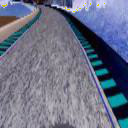

In [229]:
T.ToPILImage()(image)